# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary libraries

In [2]:
import torch
import os, glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import torchvision
from tqdm import tqdm
from torchsummary import summary

# Bring the dataset into the working directory by extracting dataset.zip from drive

In [3]:
!unzip '/content/drive/MyDrive/ZSClassification/ZeroShotHandwrittenCharacterRecognition/Bangla/BanglaCharacterDataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Train/201/bcc000060.bmp  
  inflating: Dataset/Train/201/bcc000061.bmp  
  inflating: Dataset/Train/201/bcc000062.bmp  
  inflating: Dataset/Train/201/bcc000063.bmp  
  inflating: Dataset/Train/201/bcc000064.bmp  
  inflating: Dataset/Train/201/bcc000065.bmp  
  inflating: Dataset/Train/201/bcc000066.bmp  
  inflating: Dataset/Train/201/bcc000067.bmp  
  inflating: Dataset/Train/201/bcc000068.bmp  
  inflating: Dataset/Train/201/bcc000069.bmp  
  inflating: Dataset/Train/201/bcc000070.bmp  
  inflating: Dataset/Train/201/bcc000071.bmp  
  inflating: Dataset/Train/201/bcc000072.bmp  
  inflating: Dataset/Train/201/bcc000073.bmp  
  inflating: Dataset/Train/201/bcc000074.bmp  
  inflating: Dataset/Train/201/bcc000075.bmp  
  inflating: Dataset/Train/201/bcc000076.bmp  
  inflating: Dataset/Train/201/bcc000077.bmp  
  inflating: Dataset/Train/201/bcc000078.bmp  
  inflating: Dataset/Train/201/bcc000079.bmp  
  inflati

# Hyperparameters

In [4]:
ROOT_DIR = '/content/Dataset'
TRAIN_ROOT = os.path.join(ROOT_DIR, 'Train')
TEST_ROOT = os.path.join(ROOT_DIR, 'Test')
CHECKPOINT = ''

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = (32, 32)
BATCH_SIZE = 32

N_CLASSES = len(os.listdir(TRAIN_ROOT))
print(f"No. of Classes = {N_CLASSES}")

No. of Classes = 50


# Create corresponding train/valid/test Dataframes

In [5]:
paths = glob.glob('/content/Dataset/*/*/*.bmp')

df = pd.DataFrame({'Path': paths})

def extract_label(path):
    return path.split('/')[-2]

def extract_set(path):
    return path.split('/')[-3]

df['Label'] = df['Path'].apply(extract_label)
df = pd.concat([df, pd.get_dummies(df['Label'])], axis = 1)

df['Set'] = df['Path'].apply(extract_set)

train_df = df.loc[df['Set'] == 'Train'].iloc[:, :-1]
test_df = df.loc[df['Set'] == 'Test'].iloc[:, :-1]

In [6]:
df.head(3)

,Path,Label,172,173,174,175,176,177,178,179,...,213,214,215,216,217,218,219,220,221,Set
0,/content/Dataset/Test/178/bcc000054.bmp,178,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Test
1,/content/Dataset/Test/178/bcc000036.bmp,178,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Test
2,/content/Dataset/Test/178/bcc000047.bmp,178,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Test


In [7]:
train_df.tail(2)

,Path,Label,172,173,174,175,176,177,178,179,...,212,213,214,215,216,217,218,219,220,221
14998,/content/Dataset/Train/218/bcc000094.bmp,218,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
14999,/content/Dataset/Train/218/bcc000048.bmp,218,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [8]:
test_df.sample(4)

,Path,Label,172,173,174,175,176,177,178,179,...,212,213,214,215,216,217,218,219,220,221
2188,/content/Dataset/Test/181/bcc000032.bmp,181,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1607,/content/Dataset/Test/202/bcc000003.bmp,202,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2007,/content/Dataset/Test/175/bcc000008.bmp,175,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2884,/content/Dataset/Test/210/bcc000042.bmp,210,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualize a random instance from the dataset

Shape of the image: (61, 73, 3)


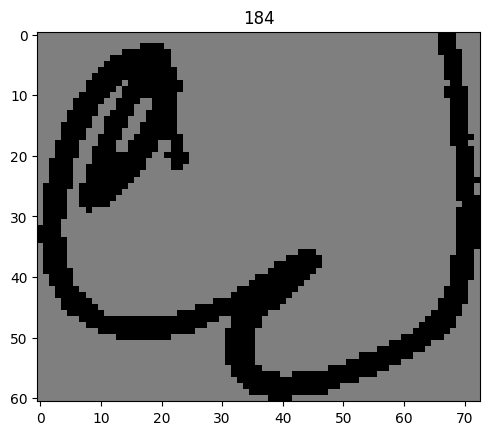

In [9]:
def imshow():
    idx = random.randint(0, len(train_df))
    img = plt.imread(train_df['Path'][idx])
    label = train_df['Label'][idx]
    print(f"Shape of the image: {img.shape}")
    plt.imshow(img)
    plt.title(label)
    plt.show()

imshow()

# Custom Dataloader to read and process the images from dfs

In [10]:
class CustomDatasetLoader(torch.utils.data.Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        path = self.df.iloc[idx, 0]
        img = cv2.imread(path)
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.from_numpy(self.df.iloc[idx, 2:].values.astype(float))

        return (img, label)

In [11]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(IMG_SIZE),
    torchvision.transforms.ToTensor(),
])

train_data = CustomDatasetLoader(df = train_df, transform = transform)
test_data = CustomDatasetLoader(df = test_df, transform = transform)
all_data = CustomDatasetLoader(df = df.iloc[:, :-1], transform = transform)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data, batch_size = 32, shuffle = True, num_workers = 1, drop_last = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)
all_data_loader = torch.utils.data.DataLoader(
    dataset = all_data, batch_size = 64, shuffle = True, num_workers = 1, drop_last = False
)

In [12]:
for (images, labels) in all_data_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 3, 32, 32])
torch.Size([64, 50])


# Model: LeNet

In [13]:
class LeNet(torch.nn.Module):
    def __init__(self, N_CLASSES=50):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5), stride=(1, 1), padding=0)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1))
        self.conv3 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = torch.nn.Linear(in_features=120, out_features=84)
        self.fc2 = torch.nn.Linear(in_features=84, out_features=N_CLASSES)
        # self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.avgpool = torch.nn.AvgPool2d(kernel_size=(2, 2), stride=(2,2))
    
    def forward(self, img): 
        # img: BSx3x32x32
        img = self.avgpool(self.tanh(self.conv1(img)))
        # conv1: BSx6x28x28 // avgpool: BSx6x14x14
        img = self.avgpool(self.tanh(self.conv2(img)))
        # conv2: BSx16x10x10 // avgpool: BSx16x5x5
        img = self.tanh(self.conv3(img))
        # conv3: BSx120x1x1
        img = img.reshape(img.shape[0], -1)
        # flatten: BSx120
        img = self.tanh(self.fc1(img))
        img = self.fc2(img)
        return img

In [14]:
model = LeNet().to(DEVICE)

random_batch = torch.randn(12, 3, 32, 32)
output = model(random_batch.to(DEVICE))

print(f"{output.shape}\n\n{output}")

torch.Size([12, 50])

tensor([[ 1.1037e-01, -6.3035e-02,  3.9230e-02,  1.4511e-01,  4.8236e-02,
         -1.0164e-01,  2.7129e-02,  3.1289e-02, -5.1176e-02,  7.2170e-02,
         -4.9359e-02,  2.8923e-02,  3.0856e-02, -1.4582e-02,  4.0726e-02,
          9.5036e-02,  9.4130e-02, -1.0325e-01, -9.4642e-03, -1.0761e-01,
          1.5254e-02,  4.2140e-02, -6.2173e-02,  1.1021e-02, -3.4828e-02,
          5.2899e-02, -3.4063e-02,  5.4977e-02, -1.0449e-02, -7.4269e-02,
          6.9075e-02,  9.3422e-02, -7.2195e-02,  1.0947e-02,  6.6659e-02,
          1.1890e-01, -8.1749e-03,  2.5626e-03,  1.3131e-02,  2.8829e-02,
         -5.4838e-02, -1.3201e-01, -1.5696e-02,  3.1291e-02, -7.4928e-02,
         -6.0906e-02,  7.8285e-02, -8.8891e-02,  1.4908e-01, -1.7725e-02],
        [ 1.0746e-01, -4.4051e-02,  3.2029e-02,  1.4404e-01,  3.7921e-02,
         -1.1185e-01, -8.9173e-03,  2.8850e-02, -7.6140e-02,  7.5896e-02,
         -4.8259e-02,  2.2190e-02,  5.9993e-02,  4.7328e-03,  5.8788e-02,
          9.625

In [15]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

65406

In [16]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 50]           4,250
Total params: 65,406
Trainable params: 65,406
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

# Training pipeline

In [17]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_count, correct_predictions, train_loss = 0, 0, 0

    for (images, labels) in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        predictions = model(images)

        optimizer.zero_grad()
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(predictions.data, 1)
        _, labels = torch.max(labels.data, 1)

        train_count += labels.shape[0]
        correct_predictions += (predictions == labels).sum().item()
        train_loss += loss.item()
    
    train_acc = correct_predictions / train_count
    train_loss = train_loss / len(train_loader)

    return train_acc, train_loss

# Validation/Test Pipeline

In [18]:
def test(model, dataloader, device):
    model.eval()
    test_count, correct_predictions = 0, 0

    with torch.no_grad():
        for (images, labels) in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            
            predictions = model(images)

            _, predictions = torch.max(predictions.data, 1)
            _, labels = torch.max(labels.data, 1)

            test_count += labels.shape[0]
            correct_predictions += (predictions == labels).sum().item()
        
        test_acc = correct_predictions / test_count

    return test_acc

# Train, validate, test, and evaluate the model, and it's performance

In [19]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [20]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    if os.path.exists('model.pth'):
        model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")
    
    if train_loss < best_loss:
        best_acc = test_acc 
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


100%|██████████| 47/47 [00:02<00:00, 19.86it/s]


Training Accuracy: 27.675%, Training Loss: 2.8498, Test Accuracy: 42.700%

--------------------
Model Saved
--------------------
Epoch: 1


100%|██████████| 47/47 [00:03<00:00, 14.48it/s]


Training Accuracy: 51.792%, Training Loss: 1.8030, Test Accuracy: 54.100%

--------------------
Model Saved
--------------------
Epoch: 2


100%|██████████| 47/47 [00:01<00:00, 23.54it/s]


Training Accuracy: 61.333%, Training Loss: 1.4119, Test Accuracy: 61.367%

--------------------
Model Saved
--------------------
Epoch: 3


100%|██████████| 47/47 [00:02<00:00, 19.09it/s]


Training Accuracy: 68.533%, Training Loss: 1.1504, Test Accuracy: 65.800%

--------------------
Model Saved
--------------------
Epoch: 4


100%|██████████| 47/47 [00:01<00:00, 24.31it/s]


Training Accuracy: 73.175%, Training Loss: 0.9605, Test Accuracy: 68.700%

--------------------
Model Saved
--------------------
Epoch: 5


100%|██████████| 47/47 [00:01<00:00, 23.66it/s]


Training Accuracy: 77.192%, Training Loss: 0.7990, Test Accuracy: 73.433%

--------------------
Model Saved
--------------------
Epoch: 6


100%|██████████| 47/47 [00:02<00:00, 19.11it/s]


Training Accuracy: 81.225%, Training Loss: 0.6697, Test Accuracy: 73.933%

--------------------
Model Saved
--------------------
Epoch: 7


100%|██████████| 47/47 [00:02<00:00, 19.23it/s]


Training Accuracy: 84.000%, Training Loss: 0.5656, Test Accuracy: 77.033%

--------------------
Model Saved
--------------------
Epoch: 8


100%|██████████| 47/47 [00:01<00:00, 24.03it/s]


Training Accuracy: 87.058%, Training Loss: 0.4801, Test Accuracy: 77.333%

--------------------
Model Saved
--------------------
Epoch: 9


100%|██████████| 47/47 [00:01<00:00, 23.82it/s]


Training Accuracy: 88.600%, Training Loss: 0.4118, Test Accuracy: 79.233%

--------------------
Model Saved
--------------------
Epoch: 10


100%|██████████| 47/47 [00:02<00:00, 23.39it/s]


Training Accuracy: 90.842%, Training Loss: 0.3526, Test Accuracy: 80.067%

--------------------
Model Saved
--------------------
Epoch: 11


100%|██████████| 47/47 [00:02<00:00, 17.70it/s]


Training Accuracy: 92.467%, Training Loss: 0.2971, Test Accuracy: 81.133%

--------------------
Model Saved
--------------------
Epoch: 12


100%|██████████| 47/47 [00:01<00:00, 23.65it/s]


Training Accuracy: 93.683%, Training Loss: 0.2542, Test Accuracy: 81.200%

--------------------
Model Saved
--------------------
Epoch: 13


100%|██████████| 47/47 [00:01<00:00, 23.92it/s]


Training Accuracy: 94.800%, Training Loss: 0.2167, Test Accuracy: 81.733%

--------------------
Model Saved
--------------------
Epoch: 14


100%|██████████| 47/47 [00:01<00:00, 24.11it/s]


Training Accuracy: 96.058%, Training Loss: 0.1793, Test Accuracy: 81.700%

--------------------
Model Saved
--------------------
Epoch: 15


100%|██████████| 47/47 [00:01<00:00, 24.32it/s]


Training Accuracy: 96.983%, Training Loss: 0.1512, Test Accuracy: 81.767%

--------------------
Model Saved
--------------------
Epoch: 16


100%|██████████| 47/47 [00:02<00:00, 17.03it/s]


Training Accuracy: 97.425%, Training Loss: 0.1290, Test Accuracy: 82.033%

--------------------
Model Saved
--------------------
Epoch: 17


100%|██████████| 47/47 [00:02<00:00, 21.48it/s]


Training Accuracy: 98.267%, Training Loss: 0.1038, Test Accuracy: 82.133%

--------------------
Model Saved
--------------------
Epoch: 18


100%|██████████| 47/47 [00:01<00:00, 23.75it/s]


Training Accuracy: 98.450%, Training Loss: 0.0918, Test Accuracy: 82.000%

--------------------
Model Saved
--------------------
Epoch: 19


100%|██████████| 47/47 [00:01<00:00, 23.68it/s]


Training Accuracy: 98.875%, Training Loss: 0.0780, Test Accuracy: 82.700%

--------------------
Model Saved
--------------------
Epoch: 20


100%|██████████| 47/47 [00:02<00:00, 22.93it/s]


Training Accuracy: 99.192%, Training Loss: 0.0631, Test Accuracy: 82.367%

--------------------
Model Saved
--------------------
Epoch: 21


100%|██████████| 47/47 [00:02<00:00, 22.97it/s]


Training Accuracy: 99.267%, Training Loss: 0.0566, Test Accuracy: 81.900%

--------------------
Model Saved
--------------------
Epoch: 22


100%|██████████| 47/47 [00:02<00:00, 17.85it/s]


Training Accuracy: 99.542%, Training Loss: 0.0464, Test Accuracy: 82.633%

--------------------
Model Saved
--------------------
Epoch: 23


100%|██████████| 47/47 [00:02<00:00, 18.09it/s]


Training Accuracy: 99.783%, Training Loss: 0.0324, Test Accuracy: 82.567%

--------------------
Model Saved
--------------------
Epoch: 24


100%|██████████| 47/47 [00:02<00:00, 22.78it/s]


Training Accuracy: 99.767%, Training Loss: 0.0289, Test Accuracy: 82.367%

--------------------
Model Saved
--------------------
Epoch: 25


100%|██████████| 47/47 [00:02<00:00, 23.05it/s]


Training Accuracy: 97.392%, Training Loss: 0.0920, Test Accuracy: 80.933%

Epoch: 26


100%|██████████| 47/47 [00:01<00:00, 23.50it/s]


Training Accuracy: 99.875%, Training Loss: 0.0243, Test Accuracy: 83.467%

--------------------
Model Saved
--------------------
Epoch: 27


100%|██████████| 47/47 [00:02<00:00, 22.99it/s]


Training Accuracy: 99.983%, Training Loss: 0.0120, Test Accuracy: 83.367%

--------------------
Model Saved
--------------------
Epoch: 28


100%|██████████| 47/47 [00:02<00:00, 21.11it/s]


Training Accuracy: 100.000%, Training Loss: 0.0094, Test Accuracy: 83.467%

--------------------
Model Saved
--------------------
Epoch: 29


100%|██████████| 47/47 [00:02<00:00, 16.65it/s]


Training Accuracy: 100.000%, Training Loss: 0.0080, Test Accuracy: 84.033%

--------------------
Model Saved
--------------------
Epoch: 30


100%|██████████| 47/47 [00:02<00:00, 22.12it/s]


Training Accuracy: 100.000%, Training Loss: 0.0070, Test Accuracy: 83.867%

--------------------
Model Saved
--------------------
Epoch: 31


100%|██████████| 47/47 [00:01<00:00, 23.60it/s]


Training Accuracy: 96.633%, Training Loss: 0.1131, Test Accuracy: 72.667%

Epoch: 32


100%|██████████| 47/47 [00:02<00:00, 22.92it/s]


Training Accuracy: 99.917%, Training Loss: 0.0127, Test Accuracy: 83.400%

Epoch: 33


100%|██████████| 47/47 [00:02<00:00, 23.44it/s]


Training Accuracy: 100.000%, Training Loss: 0.0055, Test Accuracy: 83.733%

--------------------
Model Saved
--------------------
Epoch: 34


100%|██████████| 47/47 [00:02<00:00, 22.30it/s]


Training Accuracy: 100.000%, Training Loss: 0.0049, Test Accuracy: 84.000%

--------------------
Model Saved
--------------------
Epoch: 35


100%|██████████| 47/47 [00:02<00:00, 16.55it/s]


Training Accuracy: 100.000%, Training Loss: 0.0045, Test Accuracy: 83.933%

--------------------
Model Saved
--------------------
Epoch: 36


100%|██████████| 47/47 [00:02<00:00, 21.99it/s]


Training Accuracy: 100.000%, Training Loss: 0.0042, Test Accuracy: 83.833%

--------------------
Model Saved
--------------------
Epoch: 37


100%|██████████| 47/47 [00:02<00:00, 23.25it/s]


Training Accuracy: 100.000%, Training Loss: 0.0038, Test Accuracy: 83.767%

--------------------
Model Saved
--------------------
Epoch: 38


100%|██████████| 47/47 [00:01<00:00, 23.58it/s]


Training Accuracy: 100.000%, Training Loss: 0.0035, Test Accuracy: 83.600%

--------------------
Model Saved
--------------------
Epoch: 39


100%|██████████| 47/47 [00:01<00:00, 24.06it/s]


Training Accuracy: 100.000%, Training Loss: 0.0032, Test Accuracy: 84.000%

--------------------
Model Saved
--------------------
Epoch: 40


100%|██████████| 47/47 [00:02<00:00, 23.06it/s]


Training Accuracy: 100.000%, Training Loss: 0.0028, Test Accuracy: 83.567%

--------------------
Model Saved
--------------------
Epoch: 41


100%|██████████| 47/47 [00:02<00:00, 15.90it/s]


Training Accuracy: 89.917%, Training Loss: 0.3370, Test Accuracy: 80.633%

Epoch: 42


100%|██████████| 47/47 [00:02<00:00, 21.85it/s]


Training Accuracy: 99.983%, Training Loss: 0.0036, Test Accuracy: 83.733%

Epoch: 43


100%|██████████| 47/47 [00:01<00:00, 23.84it/s]


Training Accuracy: 99.992%, Training Loss: 0.0027, Test Accuracy: 84.000%

--------------------
Model Saved
--------------------
Epoch: 44


100%|██████████| 47/47 [00:01<00:00, 23.51it/s]


Training Accuracy: 100.000%, Training Loss: 0.0021, Test Accuracy: 84.000%

--------------------
Model Saved
--------------------
Epoch: 45


100%|██████████| 47/47 [00:01<00:00, 23.65it/s]


Training Accuracy: 100.000%, Training Loss: 0.0020, Test Accuracy: 84.133%

--------------------
Model Saved
--------------------
Epoch: 46


100%|██████████| 47/47 [00:02<00:00, 23.31it/s]


Training Accuracy: 100.000%, Training Loss: 0.0019, Test Accuracy: 84.067%

--------------------
Model Saved
--------------------
Epoch: 47


100%|██████████| 47/47 [00:02<00:00, 17.79it/s]


Training Accuracy: 100.000%, Training Loss: 0.0019, Test Accuracy: 84.033%

--------------------
Model Saved
--------------------
Epoch: 48


100%|██████████| 47/47 [00:02<00:00, 20.06it/s]


Training Accuracy: 100.000%, Training Loss: 0.0018, Test Accuracy: 84.000%

--------------------
Model Saved
--------------------
Epoch: 49


100%|██████████| 47/47 [00:02<00:00, 23.13it/s]


Training Accuracy: 100.000%, Training Loss: 0.0017, Test Accuracy: 84.067%

--------------------
Model Saved
--------------------
Epoch: 50


100%|██████████| 47/47 [00:02<00:00, 23.50it/s]

Training Accuracy: 100.000%, Training Loss: 0.0016, Test Accuracy: 83.700%

--------------------
Model Saved
--------------------


# Discussion